In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.filterwarnings("ignore")


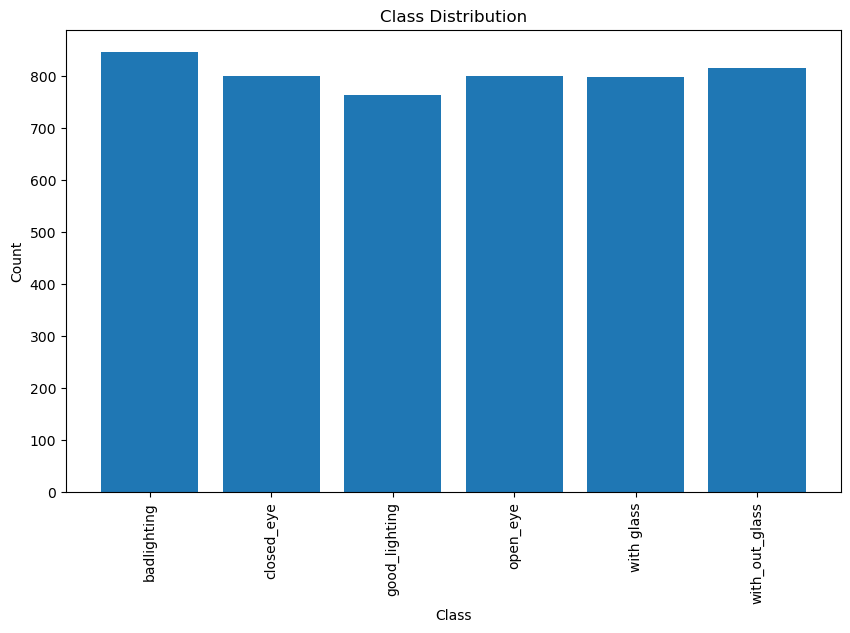

In [3]:
dataset_path = "C:\\Users\\yashu\\Downloads\\Desktop\\final year project\\training"

class_folders = os.listdir(dataset_path)

class_counts = {folder: len(os.listdir(os.path.join(dataset_path, folder))) for folder in class_folders}
class_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(10, 6))
plt.bar(class_df['Class'], class_df['Count'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

plt.xticks(rotation='vertical')

plt.show()


### CLOSED EYE, OPEN EYE TRAINING

In [4]:
def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    one_hot_labels = to_categorical(encoded_labels)
    label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    return one_hot_labels, label_mapping

def load_eye_data(folder_path, eye_labels, target_shape=(224, 224)):
    all_images = []
    all_eye_labels = []

    print("Loading and preprocessing data...")
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)

        if label not in eye_labels:
            continue

        current_label = 1 if label == 'open_eye' else 0

        print(f"Processing images for label: {label}")

        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)

            img_array = cv2.imread(file_path, cv2.IMREAD_COLOR)
            resized_img = cv2.resize(img_array, target_shape, interpolation=cv2.INTER_NEAREST)

            all_images.append(resized_img)
            all_eye_labels.append(current_label)

    print("Data loading and preprocessing complete.")
    return np.array(all_images), np.array(all_eye_labels)


folder_path = "C:\\Users\\yashu\\Downloads\\Desktop\\final year project\\training"

eye_labels = ['open_eye', 'closed_eye']
images, eye_labels = load_eye_data(folder_path, eye_labels)

common_shape = (224, 224, 3)
images = np.array([cv2.resize(img, (common_shape[1], common_shape[0])) for img in images])

eye_encoded_labels, eye_label_mapping = encode_labels(eye_labels)

print("\nNumber of images for each class before train-test split:")
for class_label in np.unique(eye_encoded_labels):
    count = np.sum(eye_encoded_labels[:, 1] == class_label)
    print(f"Class {class_label}: {count} images")

eye_X_train, eye_X_test, eye_y_train, eye_y_test = train_test_split(images, eye_encoded_labels, test_size=0.2, random_state=42, stratify=eye_encoded_labels)

print("\nNumber of training samples for each class:")
for class_label in np.unique(eye_y_train):
    count = np.sum(eye_y_train[:, 1] == class_label)
    print(f"Class {class_label}: {count} samples")

print("\nNumber of test samples for each class:")
for class_label in np.unique(eye_y_test):
    count = np.sum(eye_y_test[:, 1] == class_label)
    print(f"Class {class_label}: {count} samples")

Loading and preprocessing data...
Processing images for label: closed_eye
Processing images for label: open_eye
Data loading and preprocessing complete.

Number of images for each class before train-test split:
Class 0.0: 800 images
Class 1.0: 800 images

Number of training samples for each class:
Class 0.0: 640 samples
Class 1.0: 640 samples

Number of test samples for each class:
Class 0.0: 160 samples
Class 1.0: 160 samples


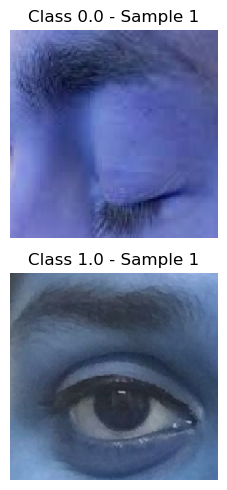

In [5]:
import matplotlib.pyplot as plt
import random

def visualize_random_images(images, labels, class_mapping, num_images=1):
    plt.figure(figsize=(10, 5))
    
    for class_label in np.unique(labels[:, 1]):
        class_indices = np.where(labels[:, 1] == class_label)[0]
        random_indices = random.sample(list(class_indices), min(num_images, len(class_indices)))
        
        for i, idx in enumerate(random_indices, start=1):
            plt.subplot(len(np.unique(labels[:, 1])), num_images, int(class_label * num_images) + i)
            plt.imshow(images[idx])
            plt.title(f"Class {class_label} - Sample {i}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_random_images(eye_X_train, eye_y_train, eye_label_mapping, num_images=1)


In [6]:
def calculate_image_statistics(images):
    flattened_images = images.reshape(images.shape[0], -1)

    channel_means = np.mean(flattened_images, axis=0)
    channel_stds = np.std(flattened_images, axis=0)

    return channel_means, channel_stds

channel_means_train, channel_stds_train = calculate_image_statistics(eye_X_train)

print("Image statistics for training images:")
print(f"Mean values for each channel: {channel_means_train}")
print(f"Standard deviation values for each channel: {channel_stds_train}")


Image statistics for training images:
Mean values for each channel: [107.1625     120.78515625 145.74921875 ... 119.37109375 136.3953125
 167.1546875 ]
Standard deviation values for each channel: [57.0828496  59.06114362 66.18119363 ... 53.24517826 53.00160649
 55.61823956]


In [94]:
import os
import cv2
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Input, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow import lite
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, DepthwiseConv2D, GlobalAveragePooling2D, Dense


## model for close and open eye


Efficient net BO, TRANSFER LEARNING

In [13]:
import warnings
warnings.filterwarnings("ignore")

eye_input = Input(shape=(common_shape[0], common_shape[1], 3), name='eye_input')

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(common_shape[0], common_shape[1], 3))

eye_branch = base_model(eye_input)

eye_flatten = layers.Flatten()(eye_branch)

eye_dropout = Dropout(0.5)(eye_flatten)

eyes_output = layers.Dense(2, activation='softmax', name='eyes_output')(eye_dropout)

model0 = Model(inputs=eye_input, outputs=eyes_output)

model0.compile(
    optimizer=Adam(learning_rate=0.00001, beta_1=0.9),  # Set momentum here
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

model0.summary()

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-6)

model_history = model0.fit(
    eye_X_train, eye_y_train,
    epochs=50,  # You can adjust the number of epochs
    batch_size=32,
    validation_data=(eye_X_test, eye_y_test),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

model0.save('Efficient_B0_c&o_model.h5')

converter = lite.TFLiteConverter.from_keras_model(model0)
tflite_model = converter.convert()

with open('Efficient_B0_c&o_model.tflite', 'wb') as f:
    f.write(tflite_model)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eye_input (InputLayer)      [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dropout_1 (Dropout)         (None, 62720)             0         
                                                                 
 eyes_output (Dense)         (None, 2)                 125442    
                                                                 
Total params: 4175013 (15.93 MB)
Trainable params: 4132990 (15.77 MB)
Non-trainable params: 42023 (164.16 KB)
_______________

INFO:tensorflow:Assets written to: C:\Users\yashu\AppData\Local\Temp\tmpedrltsku\assets


10/10 [==============================] - 11s 826ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       160
           1       0.99      0.98      0.99       160

    accuracy                           0.99       320
   macro avg       0.99      0.99      0.99       320
weighted avg       0.99      0.99      0.99       320

Accuracy: 0.9875
Precision: 0.9937
Recall: 0.9812


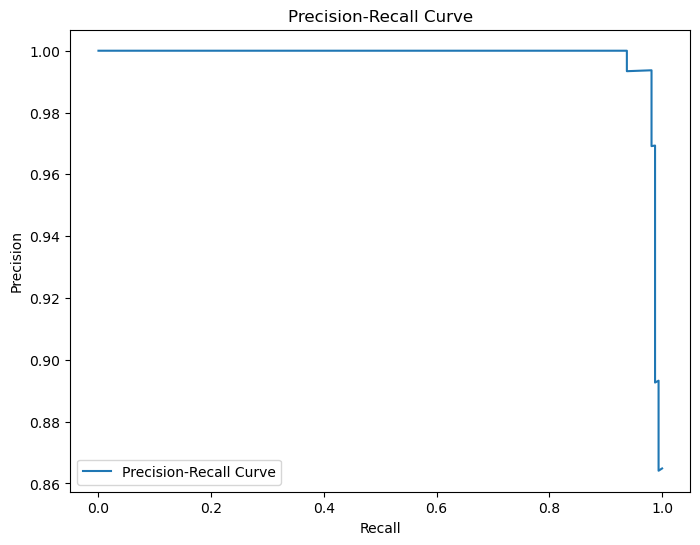

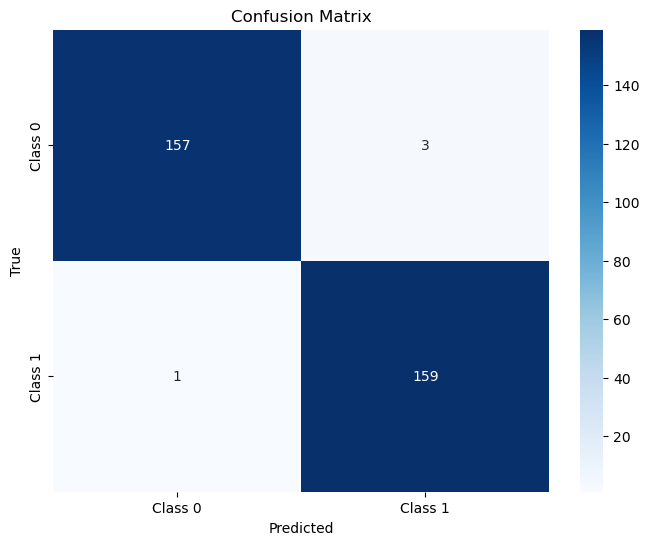

In [14]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt

model_prediction = model0.predict(eye_X_test)

y_true = np.argmax(eye_y_test, axis=1)
y_pred = np.argmax(model_prediction, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")

recall = recall_score(y_true, y_pred)
print(f"Recall: {recall:.4f}")

precision, recall, thresholds = precision_recall_curve(y_true, model_prediction[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Efficient net B1, TRANSFER LEARNING

In [10]:
import warnings
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow import lite

warnings.filterwarnings("ignore")

eye_input = Input(shape=(common_shape[0], common_shape[1], 3), name='eye_input')

base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(common_shape[0], common_shape[1], 3))

eye_branch = base_model(eye_input)

eye_flatten = Flatten()(eye_branch)

eye_dropout = Dropout(0.5)(eye_flatten)

eyes_output = Dense(2, activation='softmax', name='eyes_output')(eye_dropout)

model = Model(inputs=eye_input, outputs=eyes_output)

model.compile(
    optimizer=Adam(learning_rate=0.00001, beta_1=0.9),  # Set momentum here
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_b1.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-6)

model_history = model.fit(
    eye_X_train, eye_y_train,
    epochs=50,  # You can adjust the number of epochs
    batch_size=32,
    validation_data=(eye_X_test, eye_y_test),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

model.save('Efficient_B1_c&o_model.h5')

converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('Efficient_B1_c&o_model.tflite', 'wb') as f:
    f.write(tflite_model)


27018416/27018416 [==============================] - 13s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eye_input (InputLayer)      [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional  (None, 7, 7, 1280)        6575239   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dropout (Dropout)           (None, 62720)             0         
                                                                 
 eyes_output (Dense)         (None, 2)                 125442    
                                                                 
Total params: 6700681 (25.56 MB)
Trainable params: 6638626 (2

INFO:tensorflow:Assets written to: C:\Users\yashu\AppData\Local\Temp\tmpzatmtpck\assets


10/10 [==============================] - 12s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       160
           1       0.98      0.99      0.99       160

    accuracy                           0.99       320
   macro avg       0.99      0.99      0.99       320
weighted avg       0.99      0.99      0.99       320

Accuracy: 0.9875
Precision: 0.9815
Recall: 0.9938


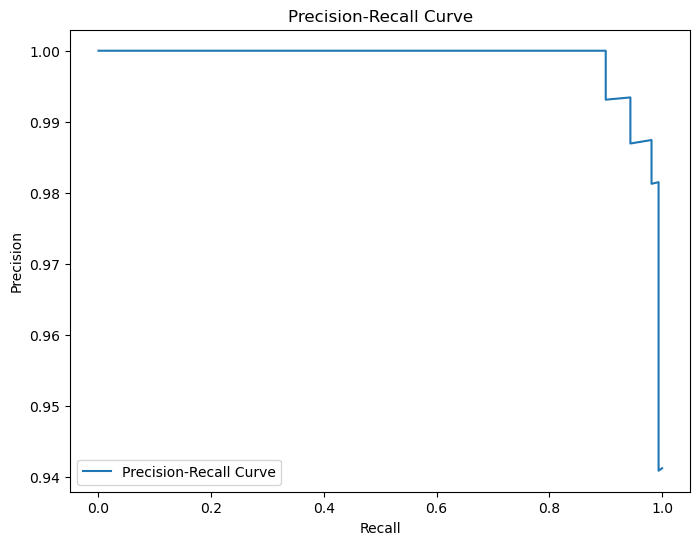

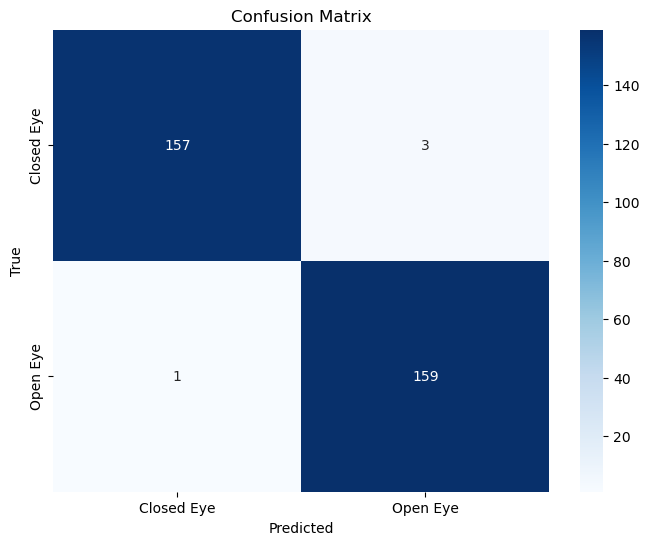

In [12]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt

model_prediction = model.predict(eye_X_test)

y_true = np.argmax(eye_y_test, axis=1)
y_pred = np.argmax(model_prediction, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")

recall = recall_score(y_true, y_pred)
print(f"Recall: {recall:.4f}")

precision, recall, thresholds = precision_recall_curve(y_true, model_prediction[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed Eye', 'Open Eye'], yticklabels=['Closed Eye', 'Open Eye'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

EFFICIENET B2

In [16]:
import warnings
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow import lite

warnings.filterwarnings("ignore")

eye_input = Input(shape=(common_shape[0], common_shape[1], 3), name='eye_input')

base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(common_shape[0], common_shape[1], 3))

eye_branch = base_model(eye_input)

eye_flatten = Flatten()(eye_branch)

eye_dropout = Dropout(0.5)(eye_flatten)

eyes_output = Dense(2, activation='softmax', name='eyes_output')(eye_dropout)

model2 = Model(inputs=eye_input, outputs=eyes_output)

model2.compile(
    optimizer=Adam(learning_rate=0.00001, beta_1=0.9),  # Set momentum here
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

model2.summary()

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_b2.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-6)

model_history = model2.fit(
    eye_X_train, eye_y_train,
    epochs=50,  # You can adjust the number of epochs
    batch_size=32,
    validation_data=(eye_X_test, eye_y_test),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

model2.save('Efficient_B2_c&o_model.h5')

converter = lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

with open('Efficient_B2_c&o_model.tflite', 'wb') as f:
    f.write(tflite_model)


31790344/31790344 [==============================] - 8s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eye_input (InputLayer)      [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb2 (Functional  (None, 7, 7, 1408)        7768569   
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 68992)             0         
                                                                 
 dropout_2 (Dropout)         (None, 68992)             0         
                                                                 
 eyes_output (Dense)         (None, 2)                 137986    
                                                                 
Total params: 7906555 (30.16 MB)
Trainable params: 7838980 (

INFO:tensorflow:Assets written to: C:\Users\yashu\AppData\Local\Temp\tmpg3apy7h5\assets


10/10 [==============================] - 15s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       160
           1       0.99      0.98      0.99       160

    accuracy                           0.99       320
   macro avg       0.99      0.99      0.99       320
weighted avg       0.99      0.99      0.99       320

Accuracy: 0.9875
Precision: 0.9937
Recall: 0.9812


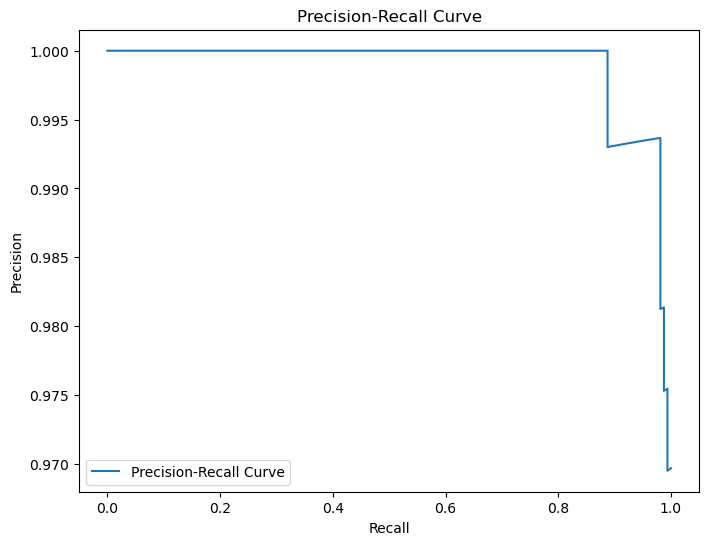

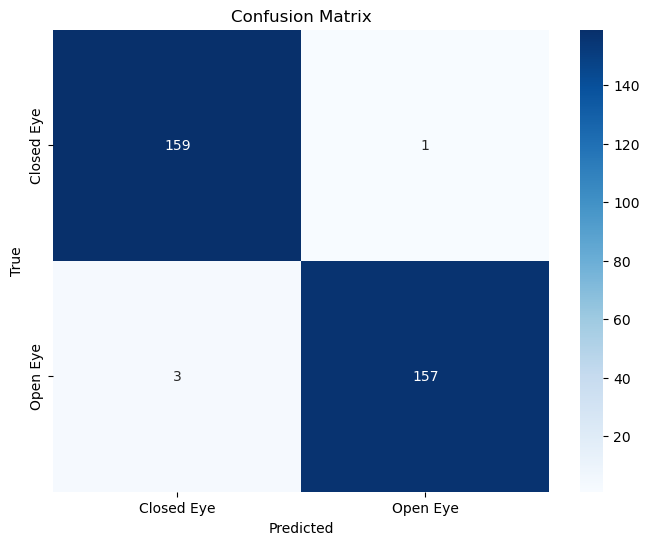

In [17]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt

model_prediction = model2.predict(eye_X_test)

y_true = np.argmax(eye_y_test, axis=1)
y_pred = np.argmax(model_prediction, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")

recall = recall_score(y_true, y_pred)
print(f"Recall: {recall:.4f}")

precision, recall, thresholds = precision_recall_curve(y_true, model_prediction[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed Eye', 'Open Eye'], yticklabels=['Closed Eye', 'Open Eye'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

customized efficientnet

In [99]:
import warnings
warnings.filterwarnings("ignore")

def efficientnet_block(x, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)  
    return x

def efficientnet_model(input_shape, num_classes, learning_rate=0.001, momentum=0.9):
    input_tensor = Input(shape=input_shape)

    x = efficientnet_block(input_tensor, filters=32, kernel_size=(3, 3), strides=2)

    num_blocks = [1, 2, 2, 3]  
    filters = [16, 24, 40, 80]  

    for i, (blocks, filters) in enumerate(zip(num_blocks, filters)):
        for j in range(blocks):
            strides = 2 if j == 0 and i != 0 else 1
            x = efficientnet_block(x, filters=filters, kernel_size=(3, 3), strides=strides)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x, name='efficientnet_model')

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=momentum)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = common_shape
num_classes = len(eye_label_mapping)
model = efficientnet_model(input_shape, num_classes, learning_rate=0.001, momentum=0.9)

checkpoint_path = "efficientnet_custom_c&n_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model.fit(eye_X_train, eye_y_train, epochs=20, validation_data=(eye_X_test, eye_y_test), callbacks=[checkpoint])

loss, accuracy = model.evaluate(eye_X_test, eye_y_test)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

best_model = tf.keras.models.load_model(checkpoint_path)

Epoch 1/20
40/40 [==============================] - ETA: 0s - loss: 0.5223 - accuracy: 0.7406
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to efficientnet_custom_c&n_model.h5
40/40 [==============================] - 32s 605ms/step - loss: 0.5223 - accuracy: 0.7406 - val_loss: 0.7767 - val_accuracy: 0.5000
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.8891
Epoch 2: val_accuracy improved from 0.50000 to 0.51250, saving model to efficientnet_custom_c&n_model.h5
40/40 [==============================] - 24s 595ms/step - loss: 0.2733 - accuracy: 0.8891 - val_loss: 0.7878 - val_accuracy: 0.5125
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 0.9438
Epoch 3: val_accuracy improved from 0.51250 to 0.62813, saving model to efficientnet_custom_c&n_model.h5
40/40 [==============================] - 22s 560ms/step - loss: 0.1658 - accuracy: 0.9438 - val_loss: 0.6360 - val_accuracy: 0.6281
Epoch 4/20

10/10 [==============================] - 1s 133ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       160
           1       0.99      0.99      0.99       160

    accuracy                           0.99       320
   macro avg       0.99      0.99      0.99       320
weighted avg       0.99      0.99      0.99       320

Accuracy: 0.9906
Precision: 0.9937
Recall: 0.9875


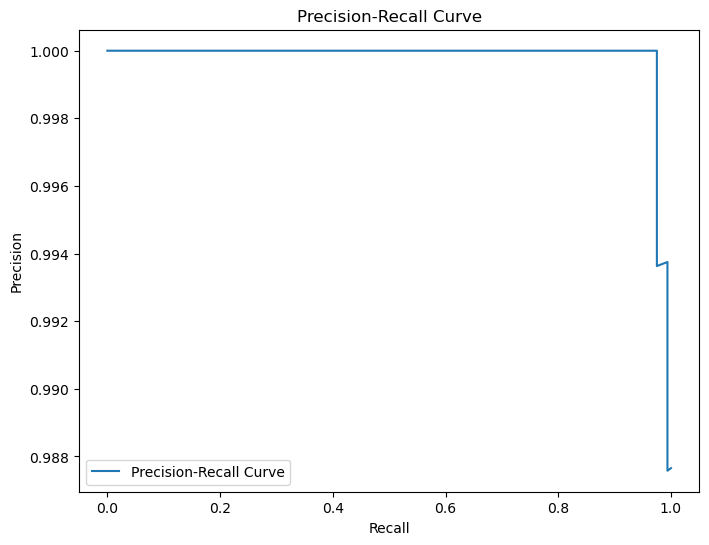

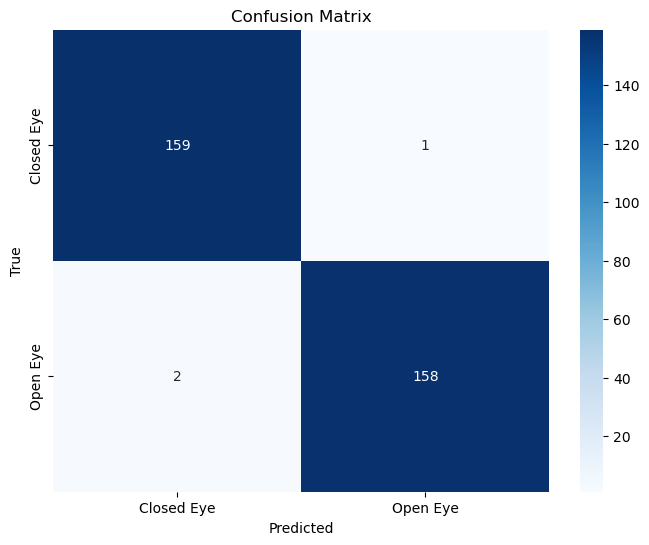

In [101]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

model_prediction = model.predict(eye_X_test)

y_true = np.argmax(eye_y_test, axis=1)
y_pred = np.argmax(model_prediction, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")

recall = recall_score(y_true, y_pred)
print(f"Recall: {recall:.4f}")

precision, recall, thresholds = precision_recall_curve(y_true, model_prediction[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed Eye', 'Open Eye'], yticklabels=['Closed Eye', 'Open Eye'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [111]:

import tensorflow as tf
from tensorflow.keras.models import load_model

model_path = 'efficientnet_custom_c&n_model.h5'
model = load_model(model_path)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_path = 'efficientnet_custom_c&n_model.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print(f'TFLite model saved to: {tflite_path}')



INFO:tensorflow:Assets written to: C:\Users\yashu\AppData\Local\Temp\tmp0oovbwtp\assets


INFO:tensorflow:Assets written to: C:\Users\yashu\AppData\Local\Temp\tmp0oovbwtp\assets


TFLite model saved to: efficientnet_custom_c&n_model.tflite


Determining size of the model 

In [102]:
import os

def get_model_size(file_path):
    file_size_bytes = os.path.getsize(file_path)
    
    file_size_mb = file_size_bytes / (1024 * 1024)
    
    return file_size_mb

model_paths = ['Efficient_B0_c&o_model.h5', 'Efficient_B1_c&o_model.h5', 'Efficient_B2_c&o_model.h5','efficientnet_custom_c&n_model.h5']

for model_path in model_paths:
    size_mb = get_model_size(model_path)
    print(f"Size of {model_path}: {size_mb:.2f} MB")


Size of Efficient_B0_c&o_model.h5: 48.30 MB
Size of Efficient_B1_c&o_model.h5: 77.36 MB
Size of Efficient_B2_c&o_model.h5: 91.12 MB
Size of efficientnet_custom_c&n_model.h5: 2.26 MB


Precision plotting

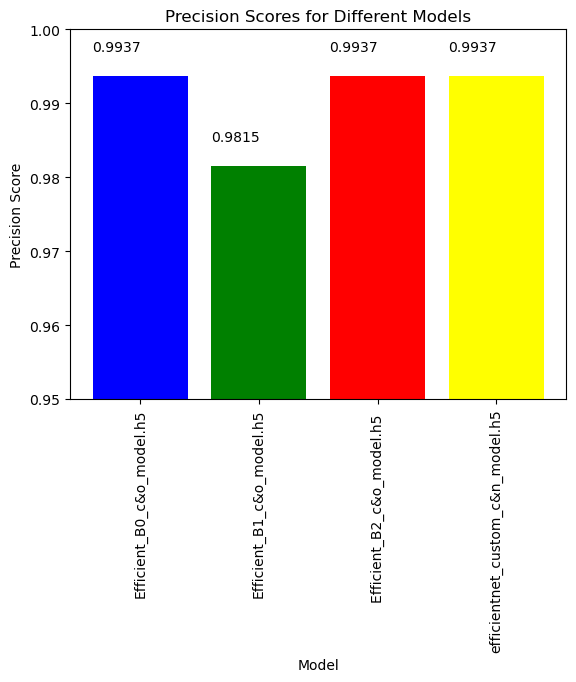

In [104]:
import matplotlib.pyplot as plt

model_names = ['Efficient_B0_c&o_model.h5', 'Efficient_B1_c&o_model.h5', 'Efficient_B2_c&o_model.h5 ','efficientnet_custom_c&n_model.h5']
precision_values = [0.9937, 0.9815, 0.9937,0.9937]  
fig, ax = plt.subplots()
bars = ax.bar(model_names, precision_values, color=['blue', 'green', 'red','yellow'])

for bar, value in zip(bars, precision_values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.20, bar.get_height() + 0.003, f'{value:.4f}', ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Precision Score')
plt.title('Precision Scores for Different Models')
plt.xticks(rotation=90)

plt.ylim(0.95, 1.0)  
plt.show()


Acuracy score

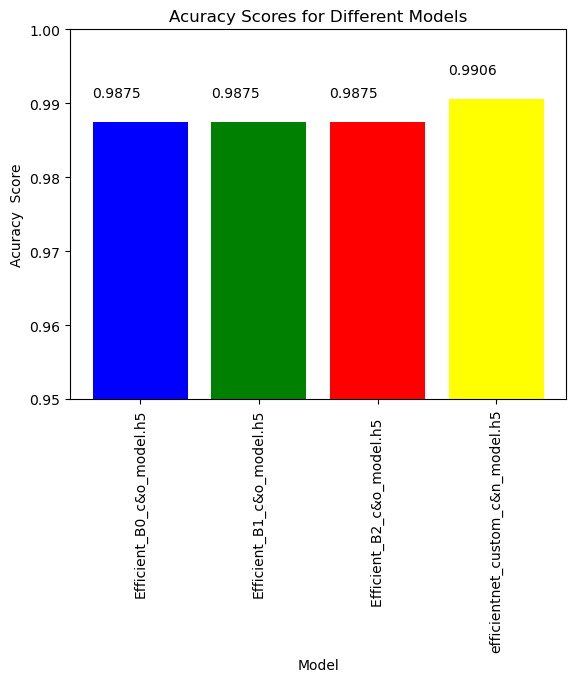

In [106]:
import matplotlib.pyplot as plt

model_names = ['Efficient_B0_c&o_model.h5', 'Efficient_B1_c&o_model.h5', 'Efficient_B2_c&o_model.h5  ', 'efficientnet_custom_c&n_model.h5']
Acuracy_values = [ 0.9875, 0.9875, 0.9875, 0.9906]  

fig, ax = plt.subplots()
bars = ax.bar(model_names, Acuracy_values, color=['blue', 'green', 'red','yellow'])

for bar, value in zip(bars,Acuracy_values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.20, bar.get_height() + 0.003, f'{value:.4f}', ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Acuracy  Score')
plt.title('Acuracy Scores for Different Models')
plt.xticks(rotation=90)

plt.ylim(0.95, 1.0) 
plt.show()



Recall scores

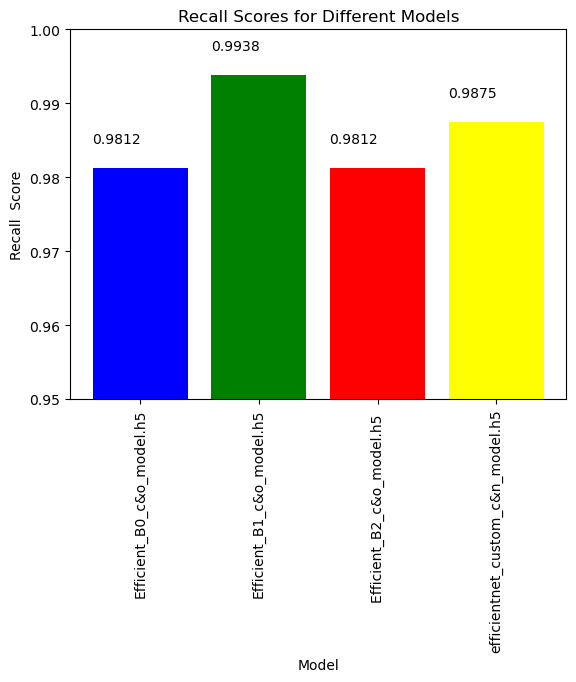

In [107]:
import matplotlib.pyplot as plt

model_names = ['Efficient_B0_c&o_model.h5', 'Efficient_B1_c&o_model.h5', 'Efficient_B2_c&o_model.h5 ', 'efficientnet_custom_c&n_model.h5']
Recall_values = [ 0.9812,0.9938, 0.9812,0.9875]

fig, ax = plt.subplots()
bars = ax.bar(model_names, Recall_values, color=['blue', 'green', 'red','yellow'])

for bar, value in zip(bars, Recall_values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.20, bar.get_height() + 0.003, f'{value:.4f}', ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Recall  Score')
plt.title('Recall Scores for Different Models')
plt.xticks(rotation=90)

plt.ylim(0.95, 1.0)  
plt.show()


model size ploting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


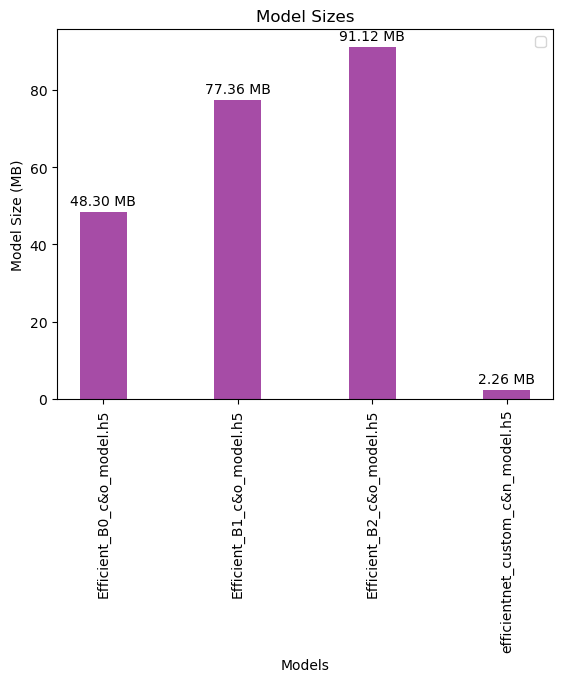

In [108]:
import os

model_paths = ['Efficient_B0_c&o_model.h5', 'Efficient_B1_c&o_model.h5', 'Efficient_B2_c&o_model.h5','efficientnet_custom_c&n_model.h5']

model_sizes = [os.path.getsize(model_path) / (1024 * 1024) for model_path in model_paths]  

bar_width = 0.35

r = np.arange(len(model_paths))

fig, ax = plt.subplots()
bars = ax.bar(r, model_sizes, width=bar_width, color='purple', alpha=0.7)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.annotate(f'{height:.2f} MB', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_xlabel('Models')
ax.set_xticks(r)
ax.set_xticklabels(model_paths, rotation='vertical')  
ax.set_ylabel('Model Size (MB)')
ax.set_title('Model Sizes')
ax.legend()

plt.show()


Inference Speed

Model: Efficient_B0_c&o_model.tflite
Average Inference Time: 0.17945 seconds

Model: Efficient_B1_c&o_model.tflite
Average Inference Time: 0.25986 seconds

Model: Efficient_B2_c&o_model.tflite
Average Inference Time: 0.26670 seconds

Model: efficientnet_custom_c&n_model.tflite
Average Inference Time: 0.01508 seconds



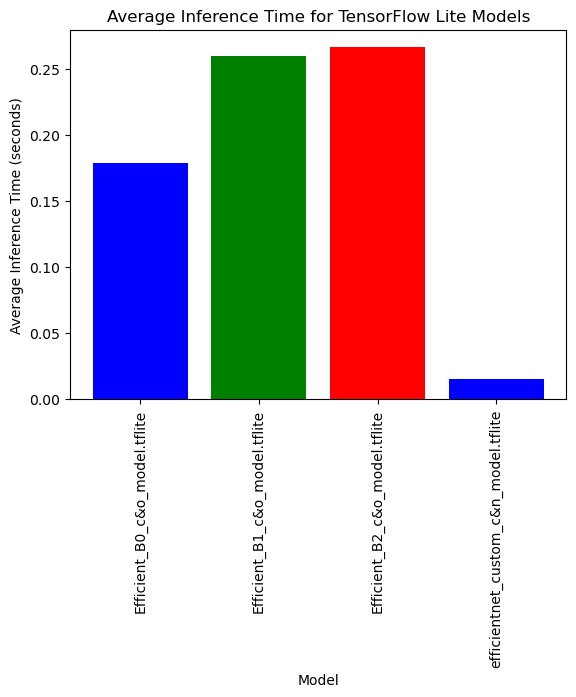

In [112]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tflite_model_paths = ['Efficient_B0_c&o_model.tflite',
                      'Efficient_B1_c&o_model.tflite',
                      'Efficient_B2_c&o_model.tflite',
                     'efficientnet_custom_c&n_model.tflite']

model_names = []
inference_times = []

for model_path in tflite_model_paths:
    print(f"Model: {model_path}")

    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_tensor_index = interpreter.get_input_details()[0]['index']

    input_data = np.random.rand(*interpreter.get_input_details()[0]['shape']).astype(np.float32)

    interpreter.set_tensor(input_tensor_index, input_data)
    interpreter.invoke()

    start_time = time.time()
    for _ in range(100):  
        interpreter.set_tensor(input_tensor_index, input_data)
        interpreter.invoke()
    end_time = time.time()

    average_inference_time = (end_time - start_time) / 100  
    print(f'Average Inference Time: {average_inference_time:.5f} seconds\n')

    model_names.append(model_path)
    inference_times.append(average_inference_time)

plt.bar(model_names, inference_times, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Average Inference Time (seconds)')
plt.title('Average Inference Time for TensorFlow Lite Models')
plt.xticks(rotation=90)
plt.show()


In [2]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import os

model_paths = [
    'Efficient_B0_c&o_model.h5',
    'Efficient_B1_c&o_model.h5',
    'Efficient_B2_c&o_model.h5',
    'efficientnet_custom_c&n_model.h5'
]

output_folder = r'C:\Users\yashu\Downloads\Desktop\final year project\PROJECT REPORT'

os.makedirs(output_folder, exist_ok=True)

for model_path in model_paths:
    model = load_model(model_path)

    model_name = os.path.splitext(os.path.basename(model_path))[0]

    architecture_path = os.path.join(output_folder, f'{model_name}_architecture.png')
    plot_model(model, to_file=architecture_path, show_shapes=True, show_layer_names=True)

    print(f"Architecture details of {model_name} saved at: {architecture_path}")




Architecture details of Efficient_B0_c&o_model saved at: C:\Users\yashu\Downloads\Desktop\final year project\PROJECT REPORT\Efficient_B0_c&o_model_architecture.png
Architecture details of Efficient_B1_c&o_model saved at: C:\Users\yashu\Downloads\Desktop\final year project\PROJECT REPORT\Efficient_B1_c&o_model_architecture.png
Architecture details of Efficient_B2_c&o_model saved at: C:\Users\yashu\Downloads\Desktop\final year project\PROJECT REPORT\Efficient_B2_c&o_model_architecture.png
Architecture details of efficientnet_custom_c&n_model saved at: C:\Users\yashu\Downloads\Desktop\final year project\PROJECT REPORT\efficientnet_custom_c&n_model_architecture.png
